In [1]:
import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype

from sklearn.ensemble  import RandomForestClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedGroupKFold, KFold

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, get_scorer_names
from sklearn.metrics import f1_score, make_scorer, accuracy_score, recall_score, precision_score
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import graphviz

import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
filepath = '/content/drive/My Drive/EColi_ML_CSV_files/'

All_Drugs_df = pd.read_csv(filepath+"EColi_Merged_df.csv", na_values="NaN")
All_Drugs_df.head()

<ipython-input-2-c2555a6b2d8b>:5: DtypeWarning: Columns (5,6,7,8,10,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  All_Drugs_df = pd.read_csv(filepath+"EColi_Merged_df.csv", na_values="NaN")


MLST     Isolate    Year CTZ  CTX  AMP AMX AMC TZP CXM  ... group_48768  \
0   ST68  11679_6#21  2001.0   S  NaN  NaN   S   S   S   R  ...           0   
1  ST652  11658_6#85  2005.0   S    S  NaN   S   S   S   S  ...           0   
2   ST95  11657_6#45  2005.0   S    S  NaN   R   R   R   S  ...           0   
3   ST73  11658_4#53  2005.0   S    S  NaN   R   S   S   S  ...           0   
4   ST73  11658_4#54  2005.0   S    S  NaN   R   S   S   S  ...           0   

  group_48873 group_48916 group_48933 group_48937  group_48958  group_49020  \
0           0           0           0           0            0            0   
1           0           0           0           0            0            0   
2           0           0           0           0            0            0   
3           0           0           0           0            0            0   
4           0           0           0           0            0            0   

   group_49174  group_49253  group_49257  
0            0            0            0  
1            0            0            0  
2            0            0            0  
3            0            0            0  
4            0            0            0  

[5 rows x 17213 columns]

In [3]:
def Split_train_test_antibiotic(drug):
  df_list = [All_Drugs_df[["MLST","Isolate",drug,"Year"]], All_Drugs_df.iloc[:,15:]]

  Drug_df = pd.concat(df_list, axis=1)

  Drug_df = Drug_df.dropna()

  Train_test_dic = {}

  labels = Drug_df[drug]

  features = Drug_df.drop(columns=[drug])

  features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.20, random_state=42, stratify=labels)

  Train_test_dic['labels_train'] = labels_train
  Train_test_dic['features_train'] = features_train
  Train_test_dic['labels_test'] = labels_test
  Train_test_dic['features_test'] = features_test

  return Train_test_dic

In [4]:
CTX_Train_test_dic = Split_train_test_antibiotic("CTX")

print("CTX")
for k, df in CTX_Train_test_dic.items():
  print(k, df.shape)
  if k.startswith("label"):
    print(df.value_counts())

CTX
labels_train (1440,)
CTX
S    1138
R     302
Name: count, dtype: int64
features_train (1440, 17201)
labels_test (361,)
CTX
S    285
R     76
Name: count, dtype: int64
features_test (361, 17201)


In [5]:
combo_list = ['Y', 'G', 'GY']

def combo_feat(features_df, drug, combo):

  year_filter = [col for col in features_df if col.startswith("Year")]
  year_feat = features_df[year_filter]

  gene_presc_filter = [col for col in features_df.columns if col not in year_filter and col != "Isolate"]
  gene_presc_feat = features_df[gene_presc_filter]

  if combo == 'Y':
    df_list = [features_df[['MLST','Isolate']], year_feat]
    Y_feat_df = pd.concat(df_list, axis=1)
    Y_feat_df = Y_feat_df.drop(columns=['Isolate'])
    return Y_feat_df

  if combo == 'G':
    df_list = [features_df['Isolate'], gene_presc_feat]
    G_feat_df = pd.concat(df_list, axis=1)
    G_feat_df = G_feat_df.drop(columns=['Isolate'])
    return G_feat_df

  if combo == 'GY':
    df_list = [features_df['Isolate'], year_feat, gene_presc_feat]
    GY_feat_df = pd.concat(df_list, axis=1)
    GY_feat_df = GY_feat_df.drop(columns=['Isolate'])
    return GY_feat_df

In [6]:
CTX_G_train_df = combo_feat(CTX_Train_test_dic['features_train'],"CTX","G")

CTX_G_train_df.columns

Index(['MLST', 'yeiU', 'yhhS', 'ybaE', 'eutR', 'ibrB', 'ytfP', 'aslB', 'narQ',
       'tolR',
       ...
       'group_48768', 'group_48873', 'group_48916', 'group_48933',
       'group_48937', 'group_48958', 'group_49020', 'group_49174',
       'group_49253', 'group_49257'],
      dtype='object', length=17199)

In [7]:
def run_RF(feat_train, lab_train, drug, combo):
  print(drug +" Training combo: "+ combo)
  feat = feat_train.drop(columns=["MLST"])
  RF = RandomForestClassifier(random_state = 42)
  RF = RF.fit(feat, lab_train)
  print("Number of Decicion Trees in RF model:", len(RF))
  return RF

In [8]:
RF_CTX_G_model = run_RF(CTX_G_train_df,CTX_Train_test_dic["labels_train"],"CTX","G")
RF_CTX_G_model

CTX Training combo: G
Number of Decicion Trees in RF model: 100


RandomForestClassifier(random_state=42)

In [9]:
index= 3

single_tree = tree.export_graphviz(RF_CTX_G_model.estimators_[index], out_file=None,
                                  feature_names=CTX_G_train_df.iloc[:,1:17199].columns,
                                  filled=True, rounded=True,
                                  special_characters=True,
                                  max_depth=None)
graph = graphviz.Source(single_tree)

In [10]:
graph.render("/content/drive/MyDrive/EColi_ML_Plots/RF_Classification Tree #: "+ str(index))

'/content/drive/MyDrive/EColi_ML_Plots/RF_Classification Tree #: 3.pdf'

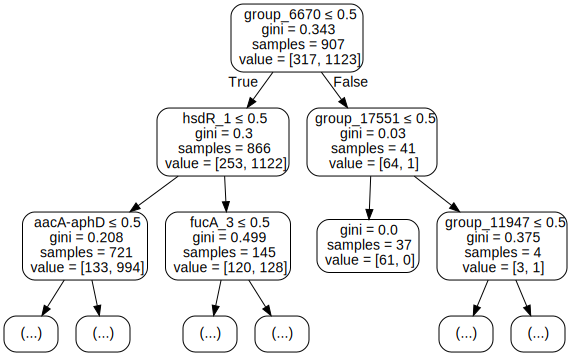

In [11]:
index= 3

chopped_tree = tree.export_graphviz(RF_CTX_G_model.estimators_[index], out_file=None,
                                  feature_names=CTX_G_train_df.iloc[:,1:17199].columns,
                                  filled=False, rounded=True,
                                  special_characters=True,
                                  max_depth=2)
graph = graphviz.Source(chopped_tree)
display(graph)

In [12]:
RF_CTX_G_model.classes_

array(['R', 'S'], dtype=object)

In [13]:
def predict(RF_combo_Model, features_test):
  feat = features_test.drop(columns=["MLST"])
  labels_pred = RF_combo_Model.predict(feat)
  if is_numeric_dtype(labels_pred):
    lab_pred_t = labels_pred.astype('O')
    lab_pred_t[lab_pred_t==0] = 'R'
    lab_pred_t[lab_pred_t==1] = 'S'
    return lab_pred_t
  else:
    return labels_pred

In [14]:
CTX_G_test_df = combo_feat(CTX_Train_test_dic['features_test'],"CTX","G")

CTX_G_labels_pred = predict(RF_CTX_G_model,CTX_G_test_df)

print("Labels predicted: ", np.unique(CTX_G_labels_pred, return_counts=True))

Labels predicted:  (array(['R', 'S'], dtype=object), array([ 65, 296]))


In [15]:
votes_for_R = 0 
votes_for_S = 0 

for i in range(0,len(RF_CTX_G_model)):
  pred = RF_CTX_G_model.estimators_[i].predict(CTX_G_test_df.iloc[0,1:17199].to_numpy().reshape(1,-1))

  if pred == 0.00:
    votes_for_R = votes_for_R + 1

  else:
    votes_for_S = votes_for_S + 1
print("Number of trees that voted Resistant: ",votes_for_R)
print("Number of trees that voted Susceptible: ",votes_for_S)

Number of trees that voted Resistant:  89
Number of trees that voted Susceptible:  11


In [16]:
pred = RF_CTX_G_model.predict(CTX_G_test_df.iloc[0,1:17199].to_numpy().reshape(1,-1))
print("Prediction by Random Forest: ", pred)

Prediction by Random Forest:  ['R']


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [17]:
def evaluate(RF_combo_model, labels_test, labels_pred, cf= True, show_results=True):
  report = classification_report(labels_test, labels_pred, output_dict = True)
  if cf == True:
    cm = confusion_matrix(labels_test, labels_pred, labels=np.unique(labels_pred))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(labels_pred))
    disp.plot()
    plt.grid(False)
    plt.show()
  if show_results == True:
    print("Results")
    print('Accuracy:',report['accuracy'])
    print('R recall:',report['R']['recall'])
    print('S recall:',report['S']['recall'])
    print('R precision:',report['R']['precision'])
    print('S precision:',report['S']['precision'])
  return [report['accuracy'], report['R']['recall'], report['S']['recall'], report['R']['precision'], report['S']['precision']]

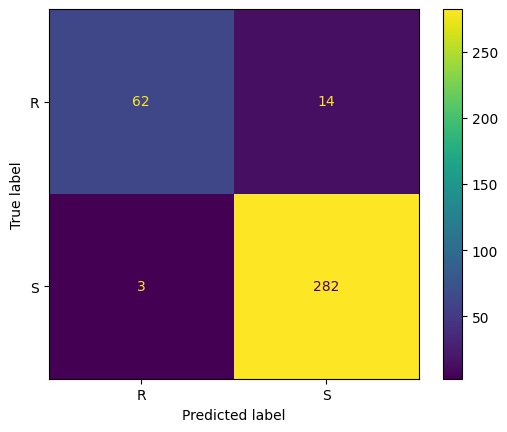

Results
Accuracy: 0.9529085872576177
R recall: 0.8157894736842105
S recall: 0.9894736842105263
R precision: 0.9538461538461539
S precision: 0.9527027027027027


In [18]:
Model_Report = evaluate(RF_CTX_G_model, CTX_Train_test_dic['labels_test'],CTX_G_labels_pred)

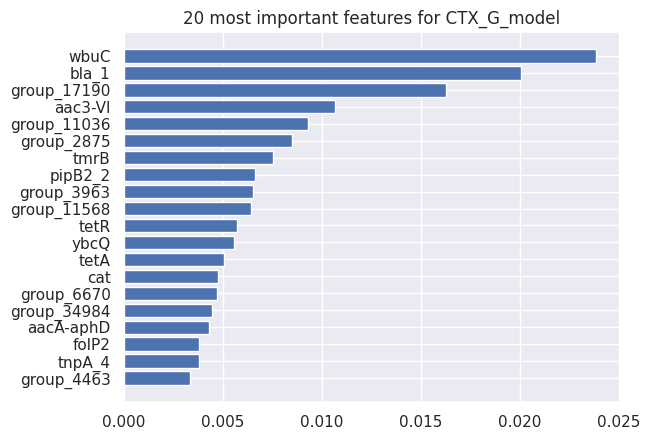

In [19]:
importance = RF_CTX_G_model.feature_importances_

indices = np.argsort(importance)[-20:]
highest_feat_importance = importance[indices]

sns.set_theme()
plt.barh([x for x in range(len(highest_feat_importance))], highest_feat_importance, tick_label=CTX_G_train_df.iloc[:,1:17199].columns[indices])
plt.title("20 most important features for CTX_G_model")

plt.savefig('/content/drive/My Drive/EColi_ML_Plots/RF_CTX_G_feat_importance.jpg',dpi=400, bbox_inches="tight")
plt.show()

In [20]:
hparam = {"n_estimators":[50, 100, 200, 300]}

In [21]:
def RF_hp_tune(param, feat_train_df, lab_train, v=3, cv=4):
  model = RandomForestClassifier(random_state = 42)
  scoring_dic = {'f1_macro':make_scorer(f1_score , average='macro')}
  feat = feat_train_df.drop(columns=["MLST"])
  lab_train_t = lab_train.replace({'R': 0, 'S': 1})
  if str(cv).isnumeric():
    cv = KFold(cv)
    gs = GridSearchCV(model, param, scoring=scoring_dic,cv=cv, refit='f1_macro', verbose=v, return_train_score=True)
    gs.fit(feat, lab_train_t)
  elif cv == "blocked":
    groups= feat_train_df['MLST']
    cv = StratifiedGroupKFold(n_splits=4)
    gs = GridSearchCV(model, param, scoring=scoring_dic,cv=cv, refit='f1_macro', verbose=v, return_train_score=True)
    gs.fit(feat, lab_train_t, groups=groups)
  else:
    print("Please provide a valid crossvalidation scheme `blocked` or an integer")
  print(gs.best_params_)
  print(gs.best_score_)
  return gs.best_estimator_

In [22]:
RF_tuned = RF_hp_tune(hparam, CTX_G_train_df, CTX_Train_test_dic['labels_train'])

<ipython-input-21-9c07d21aa091>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lab_train_t = lab_train.replace({'R': 0, 'S': 1})


Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV 1/4] END n_estimators=50; f1_macro: (train=1.000, test=0.915) total time=   1.3s
[CV 2/4] END n_estimators=50; f1_macro: (train=1.000, test=0.895) total time=   0.8s
[CV 3/4] END n_estimators=50; f1_macro: (train=0.999, test=0.897) total time=   0.8s
[CV 4/4] END n_estimators=50; f1_macro: (train=1.000, test=0.896) total time=   0.8s
[CV 1/4] END n_estimators=100; f1_macro: (train=1.000, test=0.923) total time=   2.1s
[CV 2/4] END n_estimators=100; f1_macro: (train=1.000, test=0.886) total time=   1.9s
[CV 3/4] END n_estimators=100; f1_macro: (train=1.000, test=0.917) total time=   2.2s
[CV 4/4] END n_estimators=100; f1_macro: (train=1.000, test=0.891) total time=   1.4s
[CV 1/4] END n_estimators=200; f1_macro: (train=1.000, test=0.923) total time=   2.4s
[CV 2/4] END n_estimators=200; f1_macro: (train=1.000, test=0.900) total time=   2.4s
[CV 3/4] END n_estimators=200; f1_macro: (train=1.000, test=0.916) total time=   4.2

In [23]:
drug_list = All_Drugs_df.iloc[:,3:15].columns
print(drug_list)

print(combo_list)

Index(['CTZ', 'CTX', 'AMP', 'AMX', 'AMC', 'TZP', 'CXM', 'CET', 'GEN', 'TBM',
       'TMP', 'CIP'],
      dtype='object')
['Y', 'G', 'GY']


In [24]:
for fname in os.listdir(filepath):
    if fname.endswith('RF_metrics_df.csv'):
        print("A csv with stored results for Random Forest has already been created. Please check your Google Drive directory.")
        break
else:
  RF_model_metrics = {}

  for drug in drug_list:
    print(drug)
    Test_Train_dic = Split_train_test_antibiotic(drug)
    for combo in combo_list:
      labels_train = Test_Train_dic["labels_train"]
      features_train = combo_feat(Test_Train_dic["features_train"], drug, combo)
      print(drug+"_"+combo)

      RF_combo_model = run_RF(features_train, labels_train, drug, combo)


      features_test = combo_feat(Test_Train_dic["features_test"], drug, combo)
      labels_pred = predict(RF_combo_model, features_test)
      labels_test = Test_Train_dic["labels_test"]
      report = evaluate(RF_combo_model, labels_test, labels_pred, cf=False, show_results=False)
      RF_model_metrics[drug+"_"+combo] = report
      print(report)
  RF_metrics = pd.DataFrame.from_dict(RF_model_metrics, orient='index',columns=["Accuracy", "R_recall", "S_recall", "R_precision", "S_precision"]).reset_index()
  RF_metrics = RF_metrics.rename(columns = {'index':'Drug_combo'})

  RF_metrics.to_csv(filepath+"RF_metrics_df.csv", index= False)

CTZ
CTZ_Y
CTZ Training combo: Y
Number of Decicion Trees in RF model: 100
[0.8617021276595744, 0.038461538461538464, 0.9938271604938271, 0.5, 0.8655913978494624]
CTZ_G
CTZ Training combo: G
Number of Decicion Trees in RF model: 100
[0.9095744680851063, 0.4230769230769231, 0.9876543209876543, 0.8461538461538461, 0.9142857142857143]
CTZ_GY
CTZ Training combo: GY
Number of Decicion Trees in RF model: 100
[0.9122340425531915, 0.4230769230769231, 0.9907407407407407, 0.88, 0.9145299145299145]
CTX
CTX_Y
CTX Training combo: Y
Number of Decicion Trees in RF model: 100
[0.8781163434903048, 0.42105263157894735, 1.0, 1.0, 0.8662613981762918]
CTX_G
CTX Training combo: G
Number of Decicion Trees in RF model: 100
[0.9529085872576177, 0.8157894736842105, 0.9894736842105263, 0.9538461538461539, 0.9527027027027027]
CTX_GY
CTX Training combo: GY
Number of Decicion Trees in RF model: 100
[0.9418282548476454, 0.7763157894736842, 0.9859649122807017, 0.9365079365079365, 0.9429530201342282]
AMP
AMP_Y
AMP Trai

A directory was already created to store your plot


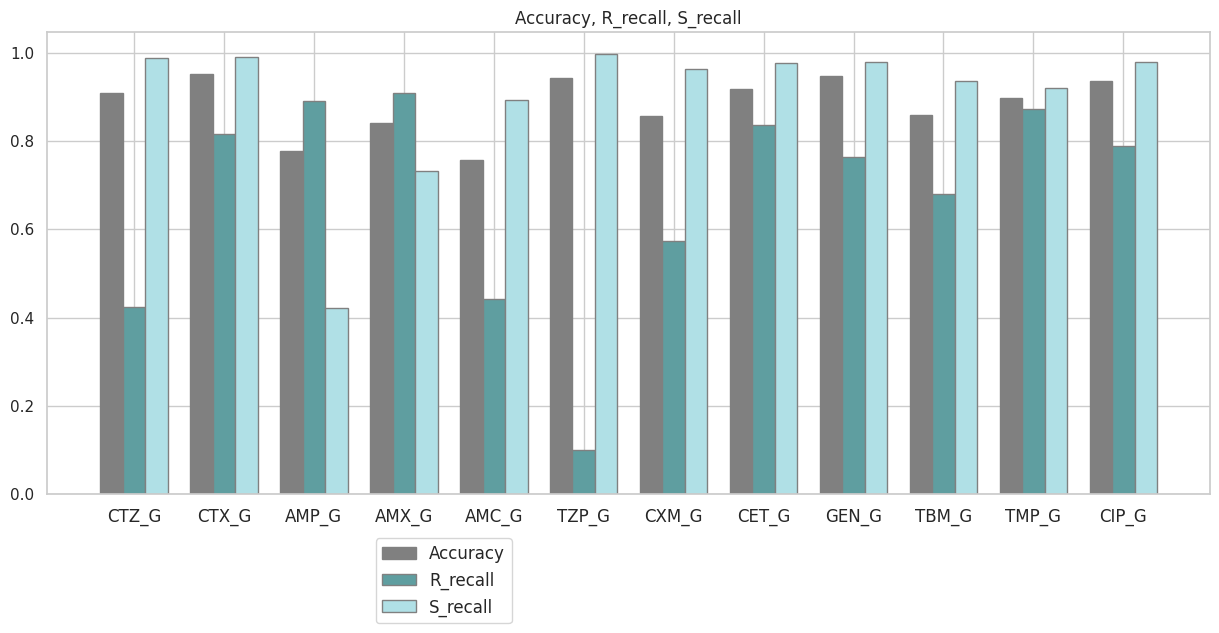

In [25]:
try:
  os.mkdir('/content/drive/My Drive/EColi_ML_Plots')
except:
  print("A directory was already created to store your plot")

RF_metrics = pd.read_csv("/content/drive/MyDrive/EColi_ML_CSV_files/RF_metrics_df.csv")
G_filter = [drug_combo for drug_combo in RF_metrics['Drug_combo'] if drug_combo.endswith("G")]
G_df = RF_metrics.loc[RF_metrics["Drug_combo"].isin(G_filter)]

sns.set_theme(style="whitegrid")
fig = plt.figure(figsize =(15, 6))

plt.title('Accuracy, R_recall, S_recall', fontsize = 12)

x = np.arange(len(G_df["Drug_combo"]))
acc = list(G_df["Accuracy"])
R_rec = list(G_df["R_recall"])
S_rec = list(G_df["S_recall"])

acc_bar=plt.bar(x-0.25, height= acc, width=0.25, color="grey", edgecolor="gray")
rrec_bar=plt.bar(x, height= R_rec, width=0.25, color="cadetblue", edgecolor="gray")
srec_bar=plt.bar(x+0.25, height= S_rec, width=0.25, color="powderblue", edgecolor="gray")

plt.xticks([r for r in range(len(G_df["Drug_combo"]))],
            G_df["Drug_combo"], fontsize = 12)

fig.legend([acc_bar,rrec_bar,srec_bar],["Accuracy", "R_recall", "S_recall"], bbox_to_anchor=(0.4,-0.35, 0.04, 0.4), fontsize=12)

plt.savefig('/content/drive/My Drive/EColi_ML_Plots/RF_G_Accuracy_and_Recall_Scores.jpg',dpi=400, bbox_inches="tight")

plt.show()